In [2]:
# インポートをここのセルにまとめる
import yaml
import os
import shutil
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
from PIL import Image
import collections
from typing import Dict, List, Tuple, Any
import math

from src.models import CAE

In [3]:
class ConvLayerInspector:
    def __init__(self, model: nn.Module):
        self.model = model
        self.conv_order: List[str] = []
        self.weights: Dict[str, torch.Tensor] = {}
        
        # 特徴マップの一時保存場所（run実行中のみ使用）
        self._temp_outputs: Dict[str, torch.Tensor] = collections.OrderedDict()
        self._handles = []
        self._register_hooks()

    def _register_hooks(self):
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Conv2d):
                self.conv_order.append(name)
                # 重みは変わらないので最初にキャッシュ（CPUへ退避）
                self.weights[name] = module.weight.detach().cpu()
                
                # フック：実行時に self._temp_outputs にデータを書き込む
                handle = module.register_forward_hook(
                    lambda m, inp, out, n=name: self._temp_outputs.setdefault(n, out.detach().cpu())
                )
                self._handles.append(handle)

    @torch.no_grad()
    def run(self, x: torch.Tensor, metadata: Any = None) -> Dict[str, Any]:
        """
        推論を実行し、特徴マップとメタデータをパッケージして返す。
        クラス内部に古い特徴マップを残さない設計に変更。
        """
        # 1. 前回のゴミが残らないようにクリア
        self._temp_outputs.clear()
        
        # 2. 推論実行（フックが発火して _temp_outputs が埋まる）
        _ = self.model(x)
        
        # 3. 結果をコピーして辞書にまとめる
        # (ここでコピーしないと、次のrunで書き換わる参照渡しになる恐れがあるため)
        result_features = {k: v.clone() for k, v in self._temp_outputs.items()}
        
        # 4. 入力情報(メタデータ)と結果をセットにして返す
        return {
            "metadata": metadata,  # ここに画像パスやIDが入る
            "features": result_features,
            "weights": self.weights # 必要な場合のみ参照できるようにする
        }

    def close(self):
        for h in self._handles:
            h.remove()
        self._handles = []

    def __enter__(self):
        # with ブロックに入ったときに呼ばれる
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        # with ブロックを抜けるとき（エラー終了含む）に必ず呼ばれる
        self.close()

# 1画像のみの場合

In [ ]:
# 設定ファイルとチェックポイントパスを指定
root_restult_dir = Path('/workspace/result')
ex_name = 'grayscale_autoencoder_v2_MSELoss_100'
config_path = root_restult_dir / ex_name / 'config.yaml'
checkpoint_path = root_restult_dir / ex_name / 'ckpts/cae_best.pth'

root_dataset_path = Path('/workspace/dataset')
dataset_name = "hpatches-sequences-release"
sean_name = "i_ajuntament"
image_name = "1.ppm"

image_path = root_dataset_path/dataset_name/sean_name/image_name


# 設定ファイルを読み込み
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# モデルを初期化
model = CAE(config)

# チェックポイントを読み込み
if Path(checkpoint_path).exists():
    model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
    print(f"✓ Loaded checkpoint from: {checkpoint_path}")
else:
    print(f"✗ Checkpoint not found: {checkpoint_path}")

# Load image
image = Image.open(image_path)

# Convert to grayscale if config specifies 1 channel
if config["dataset"]['channels'] == 1:
    image = image.convert('L')  # Grayscale

# Convert to tensor and normalize
image_tensor = transforms.ToTensor()(image)

# Add batch dimension
image_tensor = image_tensor.unsqueeze(0)
print(image_tensor.shape)  # Check shape

with ConvLayerInspector(model) as inspector:
    analysis_result = inspector.run(image_tensor, metadata={"image_path": image_path})
# Display feature map shapes
print(f"metadata: (key={analysis_result['metadata'].keys()}, value={analysis_result['metadata'].values()})")
for (layer_name, feature_map), (_, weight) in zip(analysis_result["features"].items(), analysis_result["weights"].items()):
    print(f"Layer: {layer_name}, Feature map shape: {feature_map.shape}, Weight shape: {weight.shape}")   
    

✓ Loaded checkpoint from: /workspace/result/grayscale_autoencoder_v2_MSELoss_100/ckpts/cae_best.pth
torch.Size([1, 1, 480, 640])
metadata: (key=dict_keys(['image_path']), value=dict_values([PosixPath('/workspace/dataset/hpatches-sequences-release/i_ajuntament/1.ppm')]))
Layer: encoder.0, Feature map shape: torch.Size([1, 32, 480, 640]), Weight shape: torch.Size([32, 1, 3, 3])
Layer: encoder.3, Feature map shape: torch.Size([1, 64, 240, 320]), Weight shape: torch.Size([64, 32, 3, 3])
Layer: encoder.6, Feature map shape: torch.Size([1, 128, 120, 160]), Weight shape: torch.Size([128, 64, 3, 3])
Layer: decoder.0, Feature map shape: torch.Size([1, 64, 60, 80]), Weight shape: torch.Size([64, 128, 3, 3])
Layer: decoder.3, Feature map shape: torch.Size([1, 32, 120, 160]), Weight shape: torch.Size([32, 64, 3, 3])
Layer: decoder.6, Feature map shape: torch.Size([1, 32, 240, 320]), Weight shape: torch.Size([32, 32, 3, 3])
Layer: decoder.9, Feature map shape: torch.Size([1, 1, 480, 640]), Weight s

Unique patterns number: 208030/263130836933693530167218012160000000
all pixels number: 307200


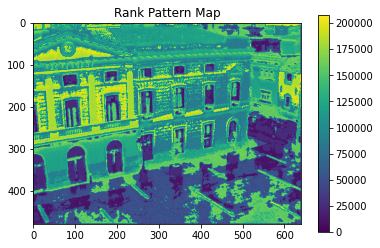

In [ ]:

# 対象の特徴マップを取得（形状取得用）
target_tensor = analysis_result["features"][inspector.conv_order[0]]
B, C, H, W = target_tensor.shape
# 各チャネルのインデックスを持つテンソルを作成
sort_target_tensor_idx = torch.argsort(target_tensor, dim=1, descending=True)

flat_perms = sort_target_tensor_idx.permute(0, 2, 3, 1).reshape(-1, C)

# 3. ユニークな行を検出し、ID (inverse indices) を取得
# return_inverse=True が重要です。これにより、各画素が「どのユニークパターンか」のIDが返ります
unique_patterns, pattern_ids = torch.unique(flat_perms, dim=0, return_inverse=True)

# 4. 画像の形 (B, H, W) に戻す
# pattern_ids を (B, H, W) の形にリシェイプ
rank_pattern_map = pattern_ids.view(B, H, W)

print(f"Unique patterns number: {pattern_ids.max()}/{math.factorial(C)}")
print(f"all pixels number: {H*W}")

# バッチの最初の画像を表示（B=1の場合）
plt.imshow(rank_pattern_map[0], cmap='viridis')  # 'viridis' はカラフルなカラーマップ
plt.colorbar()  # 色スケールを追加
plt.title("Rank Pattern Map")
plt.show()


# 2画像の場合

In [34]:
# 設定ファイルとチェックポイントパスを指定
root_restult_dir = Path('/workspace/result')
ex_name = 'grayscale_autoencoder_v2_MSELoss_100'
config_path = root_restult_dir / ex_name / 'config.yaml'
checkpoint_path = root_restult_dir / ex_name / 'ckpts/cae_best.pth'

root_dataset_path = Path('/workspace/dataset')
dataset_name = "hpatches-sequences-release"
sean_name = "i_ajuntament"
image_names = ["1.ppm", "2.ppm", "3.ppm", "4.ppm", "5.ppm", "6.ppm"] 

image_pathes = [root_dataset_path/dataset_name/sean_name/image_name for image_name in image_names]

# 設定ファイルを読み込み
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# モデルを初期化
model = CAE(config)


# チェックポイントを読み込み
if Path(checkpoint_path).exists():
    model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
    print(f"✓ Loaded checkpoint from: {checkpoint_path}")
else:
    print(f"✗ Checkpoint not found: {checkpoint_path}")
temp_image_tensors = []
for image_path in image_pathes:
    # Load image
    image = Image.open(image_path)

    # Convert to grayscale if config specifies 1 channel
    if config["dataset"]['channels'] == 1:
        image = image.convert('L')  # Grayscale

    # Convert to tensor and normalize
    image_tensor = transforms.ToTensor()(image)

    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)
    temp_image_tensors.append(image_tensor)
# Concatenate all image tensors into a single batch
image_tensor = torch.cat(temp_image_tensors, dim=0)
print(image_tensor.shape)  # Check shape

with ConvLayerInspector(model) as inspector:
    analysis_result = inspector.run(image_tensor, metadata={"image_path": image_path})

✓ Loaded checkpoint from: /workspace/result/grayscale_autoencoder_v2_MSELoss_100/ckpts/cae_best.pth
torch.Size([6, 1, 480, 640])


In [39]:
# 対象の特徴マップを取得（形状取得用）
target_tensor = analysis_result["features"][inspector.conv_order[0]]
B, C, H, W = target_tensor.shape
# 各チャネルのインデックスを持つテンソルを作成
sort_target_tensor_idx = torch.argsort(target_tensor, dim=1, descending=True)

flat_perms = sort_target_tensor_idx.permute(0, 2, 3, 1).reshape(-1, C)

# 3. ユニークな行を検出し、ID (inverse indices) を取得
# return_inverse=True が重要です。これにより、各画素が「どのユニークパターンか」のIDが返ります
unique_patterns, pattern_ids = torch.unique(flat_perms, dim=0, return_inverse=True)

# 4. 画像の形 (B, H, W) に戻す
# pattern_ids を (B, H, W) の形にリシェイプ
rank_pattern_map = pattern_ids.view(B, H, W)

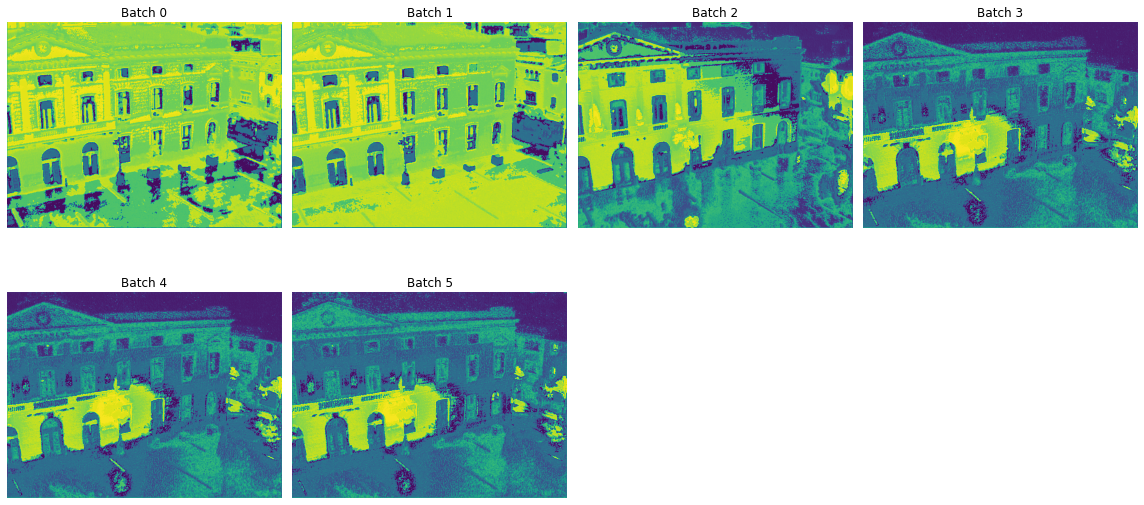

In [40]:
cols = 4  # 1行に4列
rows = (B + cols - 1) // cols  # 行数を計算（切り上げ）

# squeeze=Falseにすると、常に2次元配列(rows, cols)で返ってくるので便利ですが、
# 今回はさらに汎用的に flatten() を使う方法で書きます。
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

# 【重要】axesが1枚のとき、1次元のとき、2次元のとき、全てを「1次元リスト」に統一する
# これで axes[i] でアクセスできるようになります
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]  # 画像が1枚だけ(B=1)のときは配列じゃないのでリストに入れる

for i, ax in enumerate(axes):
    if i < B:
        # 画像がある場合
        ax.imshow(rank_pattern_map[i].cpu(), cmap='viridis') # .cpu()は念の為
        ax.set_title(f"Batch {i}")
        ax.axis('off')
    else:
        # 画像がない余りのマス（B=5なら6,7,8番目のマスなど）
        ax.axis('off') # 軸を消す
        ax.set_visible(False) # 完全に非表示にするならこちら

plt.tight_layout()
plt.show()

# encorderすべてを使う場合



In [63]:
# 設定ファイルとチェックポイントパスを指定
root_restult_dir = Path('/workspace/result')
ex_name = 'grayscale_autoencoder_v2_MSELoss_100'
config_path = root_restult_dir / ex_name / 'config.yaml'
checkpoint_path = root_restult_dir / ex_name / 'ckpts/cae_best.pth'

root_dataset_path = Path('/workspace/dataset')

# dataset_name = "hpatches-sequences-release"
# sean_name = "i_ajuntament" # 輝度変化が大きいシーケンス
# sean_name = "v_boat"      # 視点変化(回転を含む)が大きいシーケンス
# sean_name = "v_woman"   # 視点変化(回転を含まない)が大きいシーケンス
# image_names = ["1.ppm", "2.ppm", "3.ppm", "4.ppm", "5.ppm", "6.ppm"] 

dataset_name = "mydatasets"
sean_name = "jpstyle_room_wall"
image_names = [f"{i:05d}.JPG" for i in range(0, 10)]

image_pathes = [root_dataset_path/dataset_name/sean_name/image_name for image_name in image_names]

# 設定ファイルを読み込み
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# モデルを初期化
model = CAE(config)


# チェックポイントを読み込み
if Path(checkpoint_path).exists():
    model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
    print(f"✓ Loaded checkpoint from: {checkpoint_path}")
else:
    print(f"✗ Checkpoint not found: {checkpoint_path}")
temp_image_tensors = []
for image_path in image_pathes:
    # Load image
    image = Image.open(image_path)

    # Convert to grayscale if config specifies 1 channel
    if config["dataset"]['channels'] == 1:
        image = image.convert('L')  # Grayscale

    # Convert to tensor and normalize
    image_tensor = transforms.ToTensor()(image)

    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)
    temp_image_tensors.append(image_tensor)
# Concatenate all image tensors into a single batch
image_tensor = torch.cat(temp_image_tensors, dim=0)
print(image_tensor.shape)  # Check shape

with ConvLayerInspector(model) as inspector:
    analysis_result = inspector.run(image_tensor, metadata={"image_path": image_pathes})

✓ Loaded checkpoint from: /workspace/result/grayscale_autoencoder_v2_MSELoss_100/ckpts/cae_best.pth
torch.Size([10, 1, 480, 640])


In [72]:
_, _, image_H, image_W = image_tensor.shape
tmp_target_tensor = []
print(inspector.conv_order[2:3])
for conv_layer_name in inspector.conv_order[0:1]:
    # 対象の特徴マップを取得（形状取得用）
    target_tensor = analysis_result["features"][conv_layer_name]
    _, _, H, W = target_tensor.shape
    if H != image_H or W != image_W:
        target_tensor = F.interpolate(target_tensor, size=(image_H, image_W), mode='nearest')
    tmp_target_tensor.append(target_tensor)
target_tensor = torch.cat(tmp_target_tensor, dim=1)
B, C, H, W = target_tensor.shape    
# 各チャネルのインデックスを持つテンソルを作成
sort_target_tensor_idx = torch.argsort(target_tensor, dim=1, descending=True)

flat_perms = sort_target_tensor_idx.permute(0, 2, 3, 1).reshape(-1, C)

# 3. ユニークな行を検出し、ID (inverse indices) を取得
# return_inverse=True が重要です。これにより、各画素が「どのユニークパターンか」のIDが返ります
unique_patterns, pattern_ids = torch.unique(flat_perms[:, :5], dim=0, return_inverse=True)
print(f"ユニークなパターンの数: {unique_patterns.shape[0]}")
print(f"ユニークなパターン: {unique_patterns}")

# 4. 画像の形 (B, H, W) に戻す
# pattern_ids を (B, H, W) の形にリシェイプ
rank_pattern_map = pattern_ids.view(B, H, W)

['encoder.6']
ユニークなパターンの数: 1604
ユニークなパターン: tensor([[ 8,  0, 18, 29,  5],
        [ 8,  0, 29, 18,  5],
        [ 8, 18,  0,  5, 13],
        ...,
        [29, 28, 18, 20, 22],
        [29, 28, 18, 21, 10],
        [29, 28, 21, 18, 10]])


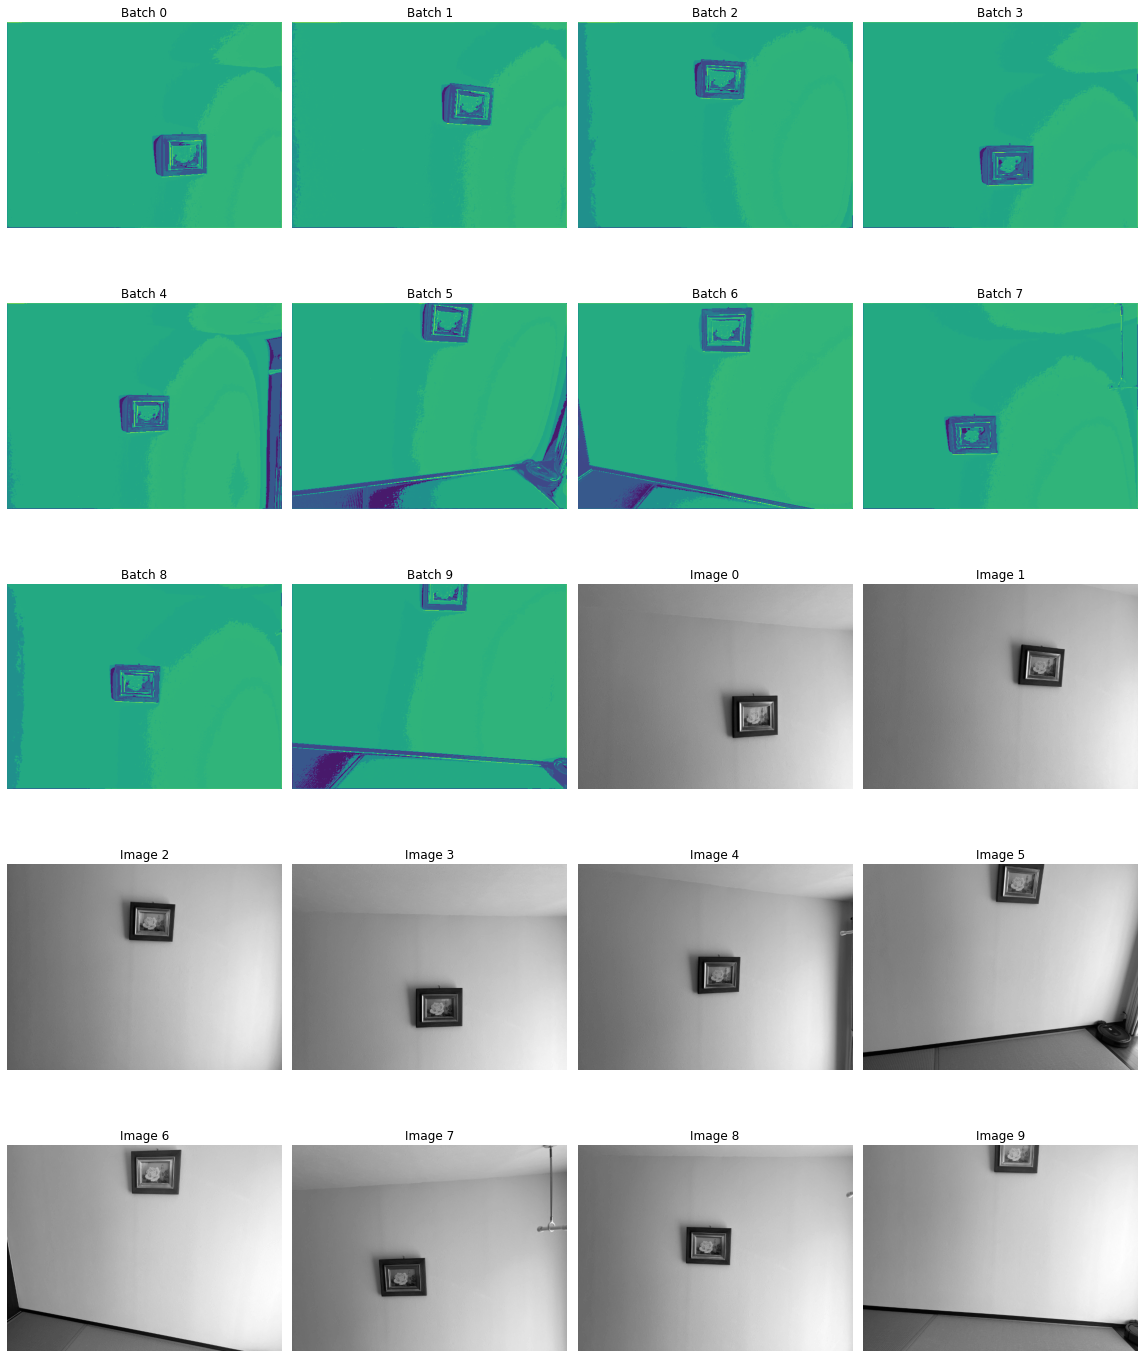

In [73]:

display_image_tensor = image_tensor.squeeze(1)

B_r, _, _ = rank_pattern_map.shape
B_i = 0
B_i, _, _ = display_image_tensor.shape
B = B_r + B_i   

cols = 4  # 1行に4列
rows = (B + cols - 1) // cols  # 行数を計算（切り上げ）

# squeeze=Falseにすると、常に2次元配列(rows, cols)で返ってくるので便利ですが、
# 今回はさらに汎用的に flatten() を使う方法で書きます。
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

# 【重要】axesが1枚のとき、1次元のとき、2次元のとき、全てを「1次元リスト」に統一する
# これで axes[i] でアクセスできるようになります
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]  # 画像が1枚だけ(B=1)のときは配列じゃないのでリストに入れる

for i, ax in enumerate(axes):
    if i < B:
        # 画像がある場合
        if i < B_r:
            ax.imshow(rank_pattern_map[i].cpu(), cmap='viridis') # .cpu()は念の為
            ax.set_title(f"Batch {i}")
            ax.axis('off')
        else:
            display_i = i - B_r
            ax.imshow(display_image_tensor[display_i].cpu(), cmap='gray') # .cpu()は念の為
            ax.set_title(f"Image {display_i}")
            ax.axis('off')
    else:
        # 画像がない余りのマス（B=5なら6,7,8番目のマスなど）
        ax.axis('off') # 軸を消す
        ax.set_visible(False) # 完全に非表示にするならこちら

plt.tight_layout()
plt.show()